# Visualise The Raster File

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff58892e4e0>)

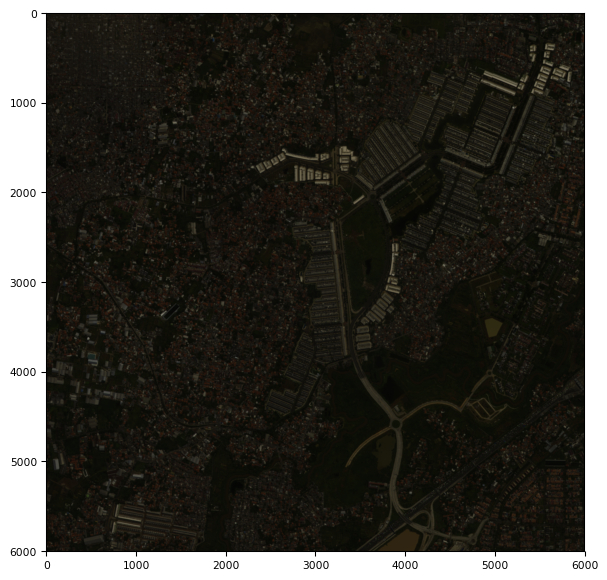

In [7]:
import rasterio
import tifffile as tiff

file = "/home/ubuntu/sukh_share/water_detection_model/source_data/Jakarta_v2/Jakarta_v2_000_pansharpen_True_2016-07-21_03:10_103001005AAD8F00.tif"
dataset = rasterio.open(file)
img = tiff.imread(file)
tiff.imshow(img[:,:,[3,2,0]])

# Get The Small Patches From The Big File

In [3]:
from PIL import Image
import numpy as np
from skimage.io import imsave, imread
from keras_unet.utils import get_patches

file = "/home/ubuntu/sukh_share/water_detection_model/source_data/Jakarta_v2/Jakarta_v2_000_pansharpen_True_2016-07-21_03:10_103001005AAD8F00.tif"

x = np.array(imread(file))
print(x.shape)
x = x[:,:,[4,2,1]]
print("x shape: ", str(x.shape))

x_crops = get_patches(
    img_arr=x, # required - array of images to be cropped
    size=512, # default is 256
    stride=512) # default is 256

print("x_crops shape: ", str(x_crops.shape))

-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


Using TensorFlow backend.


(6000, 5996, 8)
x shape:  (6000, 5996, 3)
x_crops shape:  (121, 512, 512, 3)


# Visualise Small Patches From The Big File

x_crops shape:  (121, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

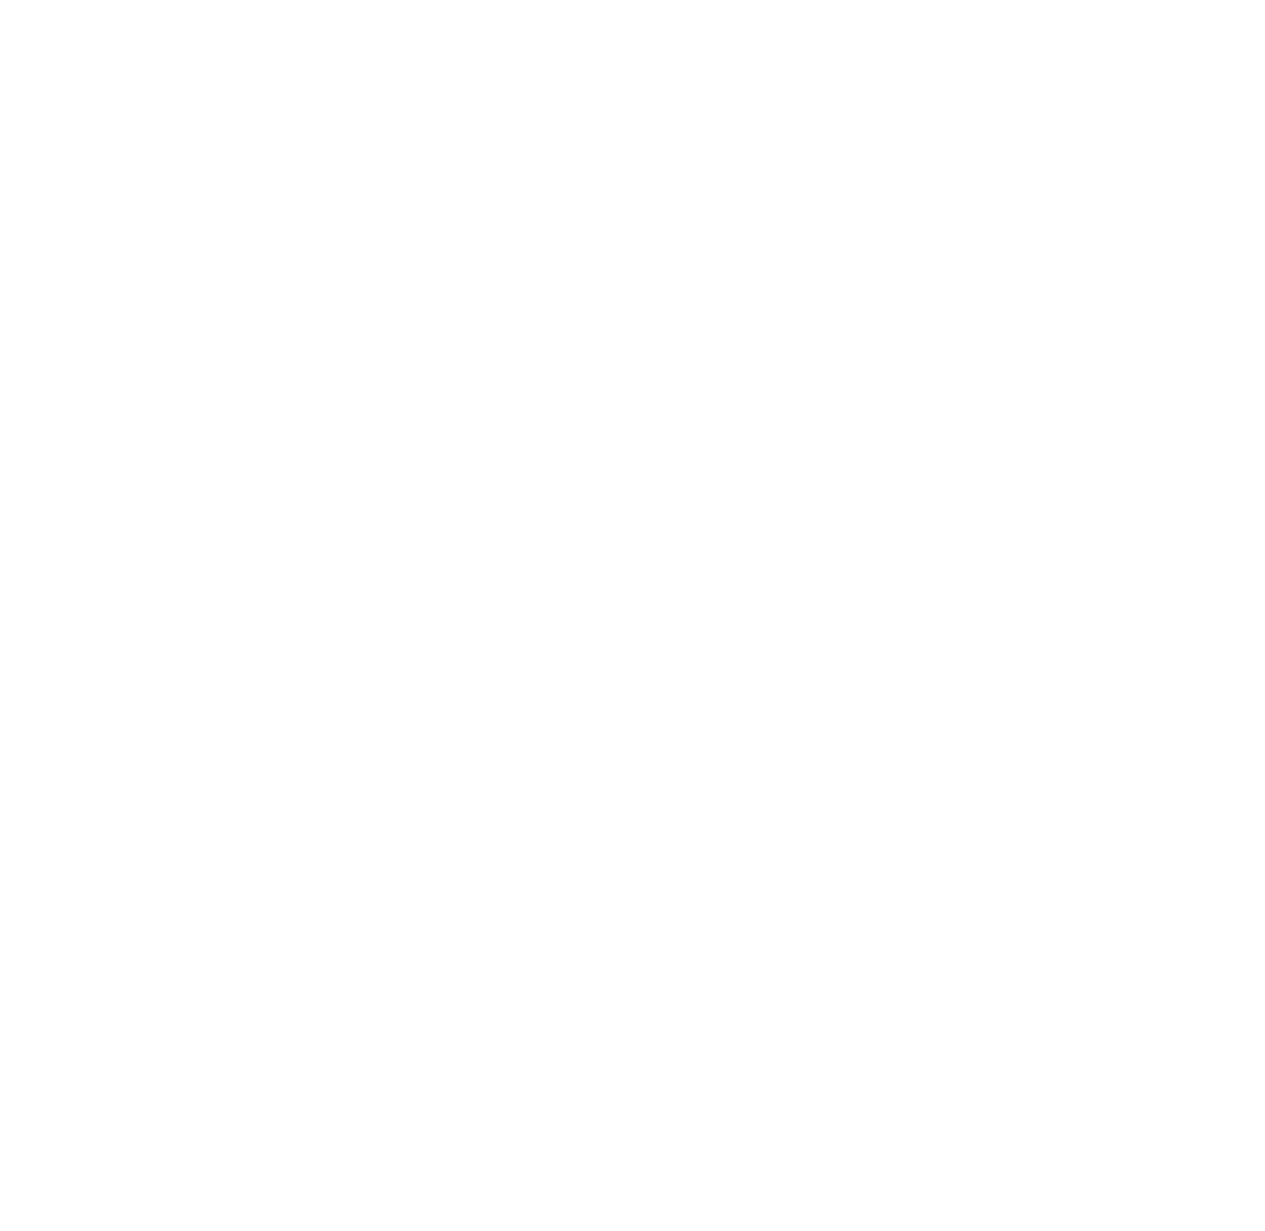

In [9]:
from keras_unet.utils import plot_patches
%matplotlib inline
   
print("x_crops shape: ", str(x_crops.shape))         
plot_patches(
    img_arr=x_crops, # required - array of cropped out images
    org_img_size=(6000, 5996), # required - original size of the image
    stride=512) # use only if stride is different from patch size

# Create The Model To Get The Inference For Large Image

In [4]:
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from keras.optimizers import Adam
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose

N = 3

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.load_weights("/home/ubuntu/sukh_share/water_detection_model/NIR_Green_Blue/model_weights/Model_unet_1.h5")

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(opt, loss=bce_jaccard_loss, metrics=[iou_score,'accuracy'])


# Know the order of the metrics

In [5]:
print(model.metrics_names)

['loss', 'iou_score', 'acc']


# Generate And Save The Inference

1/1 [==============================] - 0s 50ms/step


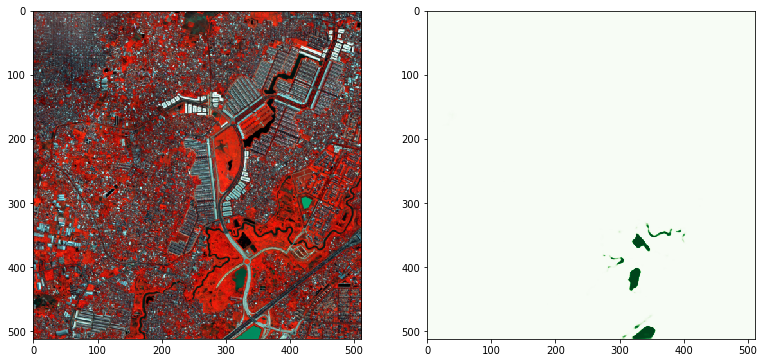

In [14]:
from PIL import Image
import numpy as np
from skimage import transform
import glob
import ntpath
from pathlib import Path
import os
import rasterio
import matplotlib.pyplot as plt

iou_score = list()
accuracy_score = list()

def load(filename, input_shape=None):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, input_shape)
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

# Specify the path for testing directory
test_raster_files = '/home/ubuntu/sukh_share/water_detection_model/source_data/Jakarta_v2_8bit/*.jpg'

raster_file_base_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/Jakarta_v2'

classification_file_base_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/big_file_results'

for file in glob.glob(test_raster_files):
    filename = ntpath.basename(file)
    base_path = str(Path(file).parent)
    image = load(file, (512,512,3))
    
    # Getting The Prediction
    result = model.predict(image, verbose=1)
    result = result[0]
    
    # get the transform and save the file
    raster_file = os.path.join(raster_file_base_path, filename.replace('jpg','tif'))
    dataset = rasterio.open(raster_file)
    profile = dataset.profile
    profile.update(count=1, compress='lzw')
    
    transform_p = dataset.meta['transform']
    
    classification_filename = os.path.join(classification_file_base_path, filename.replace('jpg','tif'))
    
    # resize the result 
    result = reshape(result[:,:,0])
    
    # write the file
    with rasterio.open(
            classification_filename,
            'w',
            **profile
        ) as dst:
            dst.write(result)
    
    # Visualisation And Comparison
    plt.figure(figsize=(20,20))
    
    # The original raster file
    plt.subplot(131)
    plt.imshow(image[0,:,:,:])
    
    # The predicted mask file
    ax = plt.subplot(132)
    plt.imshow(result[0,:,:], cmap = 'Greens')


# Visualise The Result

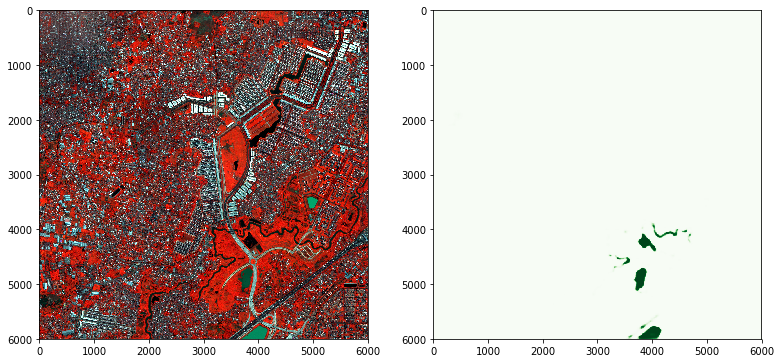

In [15]:
import tifffile as tiff
from PIL import Image
import ntpath
from pathlib import Path

classification_file = glob.glob('/home/ubuntu/sukh_share/water_detection_model/source_data/big_file_results/*.tif')
raster_file_base_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/Jakarta_v2_8bit'

for file in classification_file:
    filename = ntpath.basename(file)
    
    plt.figure(figsize=(20,20))
    
    # The original raster file
    plt.subplot(131)
    plt.imshow(Image.open(os.path.join(raster_file_base_path, filename.replace('tif','jpg'))))
    
    
    # The predicted mask file
    plt.subplot(132)
    plt.imshow(Image.open(file), cmap = 'Greens')
    